# 🤖 Step 5: Machine Learning Modeling

## Magnificent 7 Stock Prediction Project

### Objectives:
1. Time-series aware train/test split
2. Train multiple models (Random Forest, XGBoost, LightGBM)
3. Hyperparameter tuning
4. Model evaluation and comparison
5. Feature importance analysis

---

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import joblib
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Tickers
TICKERS = ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'META', 'GOOGL']

# Create models directory
os.makedirs('../models', exist_ok=True)

print('✅ Libraries loaded successfully')

✅ Libraries loaded successfully


In [2]:
# Load feature-engineered data
stock_data = {}
for ticker in TICKERS:
    file_path = f'../data/features/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    stock_data[ticker] = df
    print(f'✅ {ticker}: {len(df)} rows, {len(df.columns)} columns')

# Load combined data
df_combined = pd.read_csv('../data/features/mag7_all_features.csv', parse_dates=['Date'])
print(f'\n📊 Combined dataset: {df_combined.shape}')

✅ AAPL: 1821 rows, 117 columns
✅ MSFT: 1821 rows, 117 columns
✅ NVDA: 1821 rows, 117 columns
✅ TSLA: 1821 rows, 117 columns
✅ AMZN: 1821 rows, 117 columns
✅ META: 1821 rows, 117 columns
✅ GOOGL: 1821 rows, 117 columns

📊 Combined dataset: (12747, 118)


## 2. Feature Selection and Preparation

In [3]:
# Define feature columns (exclude targets and identifiers)
sample_df = stock_data['AAPL']

# Columns to exclude from features
exclude_cols = [
    'Ticker', 'dividends', 'stock_splits',
    'Target_Return_1D', 'Target_Return_5D', 'Target_Return_20D',
    'Target_Direction_1D', 'Target_Direction_5D',
    'Target_Big_Move_Up', 'Target_Big_Move_Down'
]

# Feature columns
feature_cols = [col for col in sample_df.columns if col not in exclude_cols]

print(f'📊 Number of features: {len(feature_cols)}')
print(f'\n🎯 Target variables available:')
print('   Classification: Target_Direction_1D, Target_Direction_5D')
print('   Regression: Target_Return_1D, Target_Return_5D, Target_Return_20D')

📊 Number of features: 107

🎯 Target variables available:
   Classification: Target_Direction_1D, Target_Direction_5D
   Regression: Target_Return_1D, Target_Return_5D, Target_Return_20D


In [4]:
# Check for any remaining missing values
print('🔍 Missing Values Check:')
for ticker in TICKERS:
    df = stock_data[ticker]
    missing = df[feature_cols].isnull().sum().sum()
    print(f'   {ticker}: {missing} missing')

# Fill any remaining NaN with 0 (should be minimal)
for ticker in TICKERS:
    stock_data[ticker] = stock_data[ticker].fillna(0)

print('\n✅ Missing values handled')

🔍 Missing Values Check:
   AAPL: 0 missing
   MSFT: 0 missing
   NVDA: 0 missing
   TSLA: 0 missing
   AMZN: 0 missing
   META: 0 missing
   GOOGL: 0 missing

✅ Missing values handled


## 3. Time-Series Train/Test Split

In [5]:
def prepare_data(df, feature_cols, target_col, test_size=0.2):
    """
    Prepare data with time-series aware split.
    Uses the last test_size % of data for testing.
    """
    # Sort by date
    df = df.sort_index()
    
    # Features and target
    X = df[feature_cols].values
    y = df[target_col].values
    
    # Time-based split
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Get test dates for plotting
    test_dates = df.index[split_idx:]
    
    return X_train, X_test, y_train, y_test, test_dates

# Example split for AAPL
X_train, X_test, y_train, y_test, test_dates = prepare_data(
    stock_data['AAPL'], feature_cols, 'Target_Direction_1D'
)

print(f'📊 Train/Test Split for AAPL:')
print(f'   Training samples: {len(X_train)}')
print(f'   Test samples: {len(X_test)}')
print(f'   Test period: {test_dates[0].strftime("%Y-%m-%d")} to {test_dates[-1].strftime("%Y-%m-%d")}')

📊 Train/Test Split for AAPL:
   Training samples: 1456
   Test samples: 365
   Test period: 2024-08-01 to 2026-01-14


In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('✅ Features scaled using StandardScaler')
print(f'   Train mean: {X_train_scaled.mean():.6f}')
print(f'   Train std: {X_train_scaled.std():.6f}')

✅ Features scaled using StandardScaler
   Train mean: -0.000000
   Train std: 1.000000


## 4. Classification Models (Direction Prediction)

In [7]:
# Define classification models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
}

print('📊 Classification Models:')
for name in classification_models:
    print(f'   • {name}')

📊 Classification Models:
   • Logistic Regression
   • Random Forest
   • XGBoost
   • LightGBM


In [8]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classification model.
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    
    return model, metrics, y_pred, y_prob

# Train and evaluate all models on AAPL
print('='*60)
print('🎯 CLASSIFICATION RESULTS (AAPL - Direction Prediction)')
print('='*60)

classification_results = {}

for name, model in classification_models.items():
    trained_model, metrics, y_pred, y_prob = evaluate_classifier(
        model, X_train_scaled, X_test_scaled, y_train, y_test, name
    )
    classification_results[name] = {
        'model': trained_model,
        'metrics': metrics,
        'predictions': y_pred,
        'probabilities': y_prob
    }
    
    print(f'\n{name}:')
    for metric, value in metrics.items():
        if value is not None:
            print(f'   {metric}: {value:.4f}')

🎯 CLASSIFICATION RESULTS (AAPL - Direction Prediction)

Logistic Regression:
   Accuracy: 0.5397
   Precision: 0.5457
   Recall: 0.8782
   F1: 0.6732
   AUC: 0.5128

Random Forest:
   Accuracy: 0.4630
   Precision: 0.5030
   Recall: 0.4213
   F1: 0.4586
   AUC: 0.4427

XGBoost:
   Accuracy: 0.5123
   Precision: 0.5415
   Recall: 0.6294
   F1: 0.5822
   AUC: 0.4999

LightGBM:
   Accuracy: 0.5205
   Precision: 0.5491
   Recall: 0.6244
   F1: 0.5843
   AUC: 0.5201


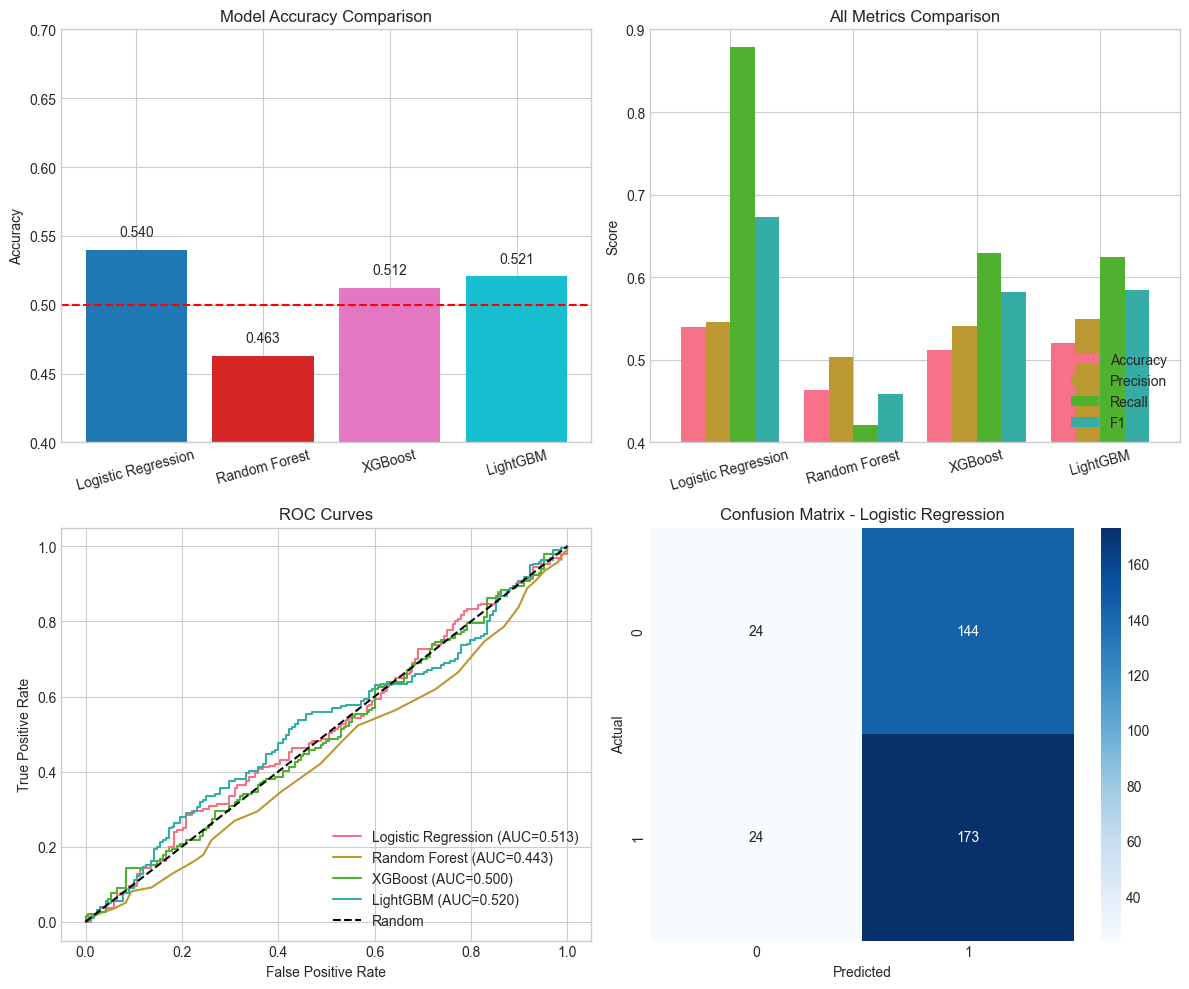

📊 Saved: models/classification_results.png


In [10]:
# Visualize classification results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Accuracy comparison
ax = axes[0, 0]
models = list(classification_results.keys())
accuracies = [classification_results[m]['metrics']['Accuracy'] for m in models]
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
bars = ax.bar(models, accuracies, color=colors)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.set_ylim(0.4, 0.7)
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.3f}', ha='center', fontsize=10)
ax.tick_params(axis='x', rotation=15)

# 2. All metrics comparison
ax = axes[0, 1]
metrics_df = pd.DataFrame({m: classification_results[m]['metrics'] for m in models}).T
metrics_df = metrics_df.drop(columns=['AUC'])
metrics_df.plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('Score')
ax.set_title('All Metrics Comparison')
ax.legend(loc='lower right')
ax.set_ylim(0.4, 0.9)
ax.tick_params(axis='x', rotation=15)

# 3. ROC curves
ax = axes[1, 0]
for name in models:
    y_prob = classification_results[name]['probabilities']
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = classification_results[name]['metrics']['AUC']
        ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(loc='lower right')

# 4. Confusion matrix for best model
ax = axes[1, 1]
best_model = max(classification_results.keys(), 
                  key=lambda x: classification_results[x]['metrics']['Accuracy'])
cm = confusion_matrix(y_test, classification_results[best_model]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_model}')

plt.tight_layout()
plt.savefig('../models/classification_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: models/classification_results.png')

## 5. Regression Models (Return Prediction)

In [11]:
# Prepare data for regression (predicting returns)
X_train_reg, X_test_reg, y_train_reg, y_test_reg, test_dates_reg = prepare_data(
    stock_data['AAPL'], feature_cols, 'Target_Return_1D'
)

# Scale
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

print(f'📊 Regression Data Prepared')
print(f'   Target: Next-day return')
print(f'   Train samples: {len(y_train_reg)}')
print(f'   Test samples: {len(y_test_reg)}')

📊 Regression Data Prepared
   Target: Next-day return
   Train samples: 1456
   Test samples: 365


In [12]:
# Define regression models
regression_models = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
}

def evaluate_regressor(model, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a regression model.
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Direction_Accuracy': np.mean((y_pred > 0) == (y_test > 0))
    }
    
    return model, metrics, y_pred

# Train and evaluate
print('='*60)
print('📈 REGRESSION RESULTS (AAPL - Return Prediction)')
print('='*60)

regression_results = {}

for name, model in regression_models.items():
    trained_model, metrics, y_pred = evaluate_regressor(
        model, X_train_reg_scaled, X_test_reg_scaled, y_train_reg, y_test_reg
    )
    regression_results[name] = {
        'model': trained_model,
        'metrics': metrics,
        'predictions': y_pred
    }
    
    print(f'\n{name}:')
    for metric, value in metrics.items():
        print(f'   {metric}: {value:.4f}')

📈 REGRESSION RESULTS (AAPL - Return Prediction)

Ridge:
   RMSE: 0.0216
   MAE: 0.0161
   R2: -0.4099
   Direction_Accuracy: 0.5233

Random Forest:
   RMSE: 0.0181
   MAE: 0.0120
   R2: 0.0115
   Direction_Accuracy: 0.5260

XGBoost:
   RMSE: 0.0210
   MAE: 0.0145
   R2: -0.3317
   Direction_Accuracy: 0.5260

LightGBM:
   RMSE: 0.0187
   MAE: 0.0128
   R2: -0.0479
   Direction_Accuracy: 0.5452


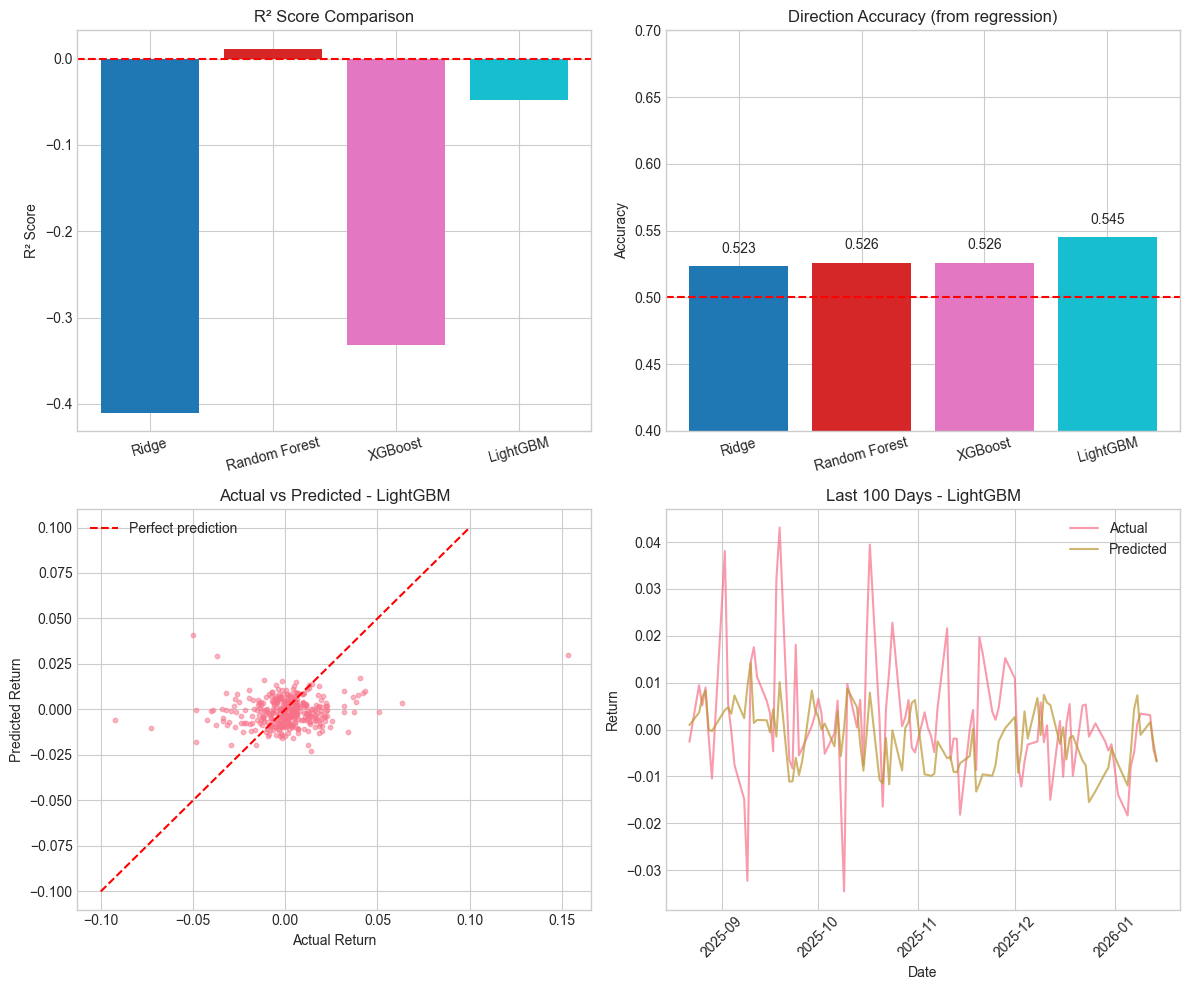

📊 Saved: models/regression_results.png


In [14]:
# Visualize regression results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Metrics comparison
ax = axes[0, 0]
models = list(regression_results.keys())
r2_scores = [regression_results[m]['metrics']['R2'] for m in models]
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
bars = ax.bar(models, r2_scores, color=colors)
ax.axhline(0, color='red', linestyle='--')
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison')
ax.tick_params(axis='x', rotation=15)

# 2. Direction accuracy
ax = axes[0, 1]
dir_acc = [regression_results[m]['metrics']['Direction_Accuracy'] for m in models]
bars = ax.bar(models, dir_acc, color=colors)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.set_ylabel('Accuracy')
ax.set_title('Direction Accuracy (from regression)')
ax.set_ylim(0.4, 0.7)
for bar, acc in zip(bars, dir_acc):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.3f}', ha='center', fontsize=10)
ax.tick_params(axis='x', rotation=15)

# 3. Actual vs Predicted (best model)
ax = axes[1, 0]
best_reg = max(regression_results.keys(), 
               key=lambda x: regression_results[x]['metrics']['Direction_Accuracy'])
y_pred_best = regression_results[best_reg]['predictions']
ax.scatter(y_test_reg, y_pred_best, alpha=0.5, s=10)
ax.plot([-0.1, 0.1], [-0.1, 0.1], 'r--', label='Perfect prediction')
ax.set_xlabel('Actual Return')
ax.set_ylabel('Predicted Return')
ax.set_title(f'Actual vs Predicted - {best_reg}')
ax.legend()

# 4. Prediction time series
ax = axes[1, 1]
ax.plot(test_dates_reg[-100:], y_test_reg[-100:], label='Actual', alpha=0.7)
ax.plot(test_dates_reg[-100:], y_pred_best[-100:], label='Predicted', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title(f'Last 100 Days - {best_reg}')
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../models/regression_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: models/regression_results.png')

## 6. Feature Importance Analysis

In [15]:
# Get feature importance from tree-based models
def get_feature_importance(model, feature_names, model_name):
    """
    Extract feature importance from a trained model.
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_).flatten()
    else:
        return None
    
    # Create dataframe
    df_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    return df_imp

# Get importance from LightGBM (usually best for tabular data)
lgbm_model = classification_results['LightGBM']['model']
df_importance = get_feature_importance(lgbm_model, feature_cols, 'LightGBM')

print('🔍 TOP 20 MOST IMPORTANT FEATURES (LightGBM):')
print('='*50)
display(df_importance.head(20))

🔍 TOP 20 MOST IMPORTANT FEATURES (LightGBM):


,Feature,Importance
44,Return_Lag_20,93
49,Volume_Ratio_Lag_5,87
42,Return_Lag_5,84
86,SP500_Return,83
82,Body_Size,82
84,Lower_Shadow,80
39,Return_Lag_1,76
38,Return,76
41,Return_Lag_3,76
40,Return_Lag_2,72


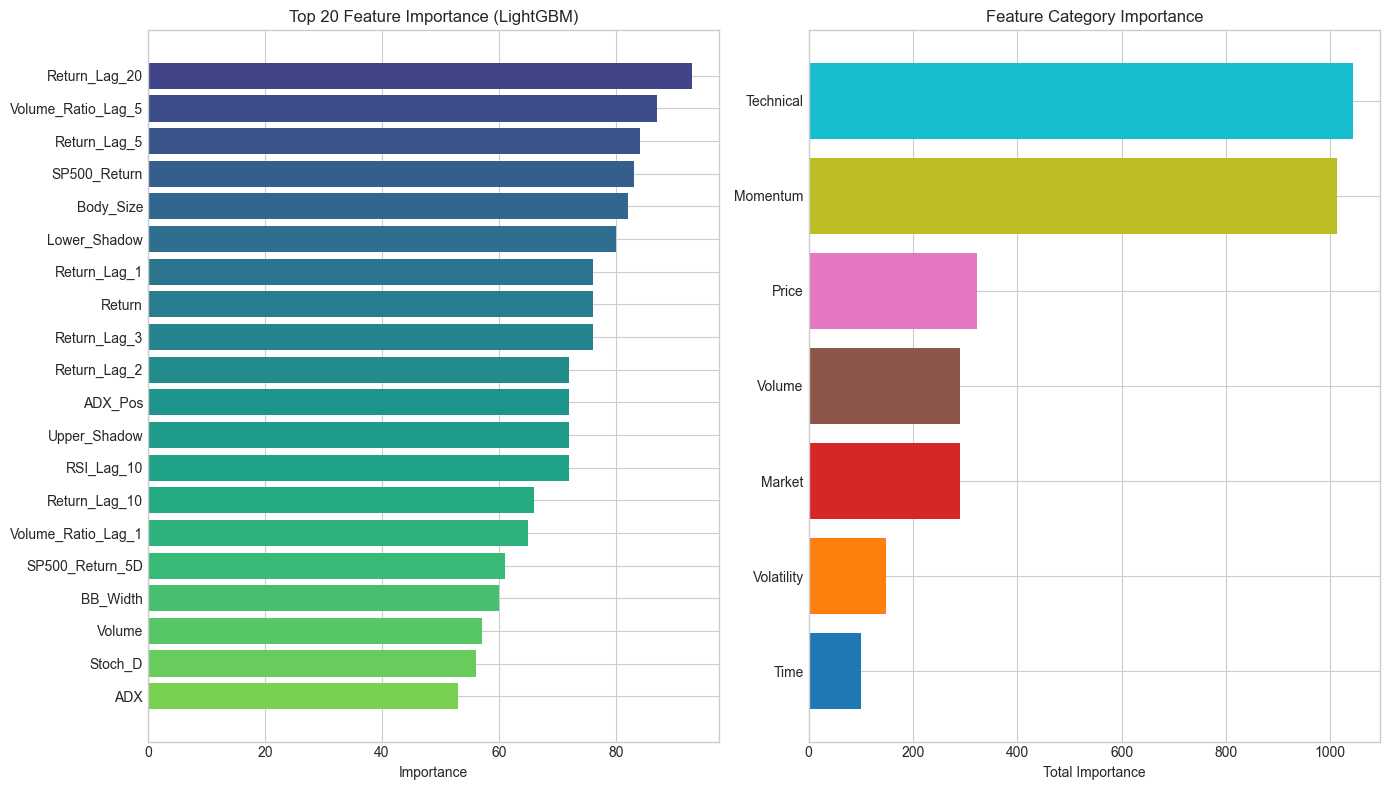

📊 Saved: models/feature_importance.png


In [17]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Top 20 features
ax = axes[0]
top_20 = df_importance.head(20)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 20))
ax.barh(range(len(top_20)), top_20['Importance'].values, color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance (LightGBM)')

# Feature category importance
ax = axes[1]

# Categorize features
categories = {
    'Technical': ['SMA', 'EMA', 'MACD', 'RSI', 'BB_', 'ADX', 'Stoch', 'ATR', 'OBV'],
    'Momentum': ['ROC', 'Return'],
    'Volume': ['Volume'],
    'Volatility': ['Volatility'],
    'Market': ['SP500', 'VIX', 'Market'],
    'Time': ['Day', 'Month', 'Quarter', 'Is_'],
    'Price': ['Open', 'High', 'Low', 'Close', 'Price_vs']
}

cat_importance = {}
for cat, patterns in categories.items():
    mask = df_importance['Feature'].apply(
        lambda x: any(p in x for p in patterns)
    )
    cat_importance[cat] = df_importance[mask]['Importance'].sum()

cat_df = pd.DataFrame.from_dict(cat_importance, orient='index', columns=['Importance'])
cat_df = cat_df.sort_values('Importance', ascending=True)

colors = plt.cm.tab10(np.linspace(0, 1, len(cat_df)))
ax.barh(cat_df.index, cat_df['Importance'], color=colors)
ax.set_xlabel('Total Importance')
ax.set_title('Feature Category Importance')

plt.tight_layout()
plt.savefig('../models/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: models/feature_importance.png')

## 7. Train Models for All Stocks

In [18]:
# Train LightGBM for all stocks (best performing model)
all_results = {}

print('='*60)
print('🎯 TRAINING LIGHTGBM FOR ALL MAGNIFICENT 7 STOCKS')
print('='*60)

for ticker in TICKERS:
    # Prepare data
    X_train, X_test, y_train, y_test, test_dates = prepare_data(
        stock_data[ticker], feature_cols, 'Target_Direction_1D'
    )
    
    # Scale
    scaler_ticker = StandardScaler()
    X_train_scaled = scaler_ticker.fit_transform(X_train)
    X_test_scaled = scaler_ticker.transform(X_test)
    
    # Train
    model = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    all_results[ticker] = {
        'model': model,
        'scaler': scaler_ticker,
        'accuracy': accuracy,
        'auc': auc,
        'test_dates': test_dates,
        'predictions': y_pred,
        'probabilities': y_prob,
        'actual': y_test
    }
    
    print(f'{ticker}: Accuracy = {accuracy:.4f}, AUC = {auc:.4f}')

print('\n✅ All models trained')

🎯 TRAINING LIGHTGBM FOR ALL MAGNIFICENT 7 STOCKS
AAPL: Accuracy = 0.5205, AUC = 0.5201
MSFT: Accuracy = 0.5397, AUC = 0.5241
NVDA: Accuracy = 0.4904, AUC = 0.4910
TSLA: Accuracy = 0.5123, AUC = 0.5494
AMZN: Accuracy = 0.4904, AUC = 0.5088
META: Accuracy = 0.5233, AUC = 0.4785
GOOGL: Accuracy = 0.5918, AUC = 0.5711

✅ All models trained


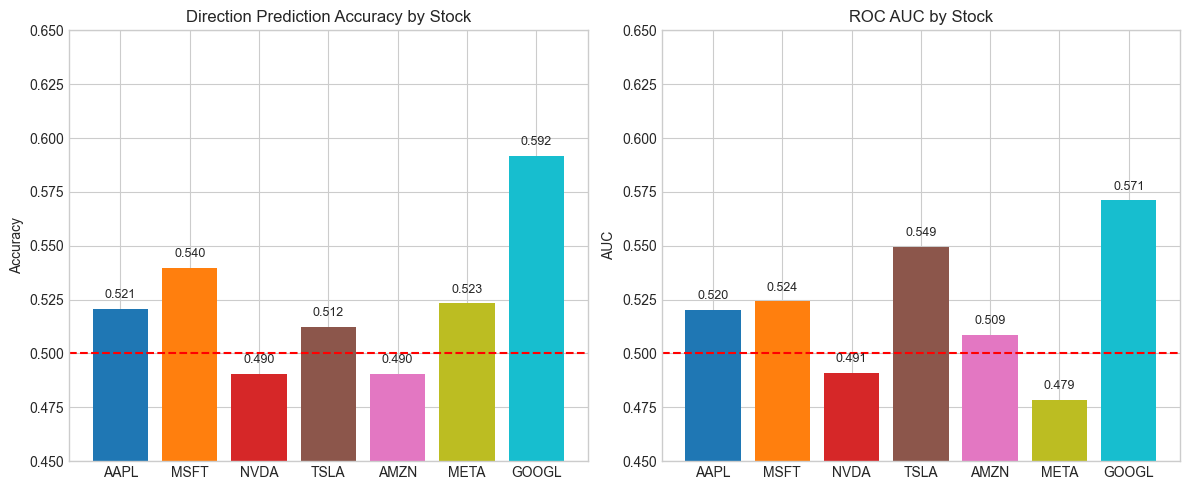

📊 Saved: models/all_stocks_results.png


In [20]:
# Visualize results for all stocks
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy by stock
ax = axes[0]
tickers = list(all_results.keys())
accuracies = [all_results[t]['accuracy'] for t in tickers]
colors = plt.cm.tab10(np.linspace(0, 1, len(tickers)))
bars = ax.bar(tickers, accuracies, color=colors)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.set_ylabel('Accuracy')
ax.set_title('Direction Prediction Accuracy by Stock')
ax.set_ylim(0.45, 0.65)
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{acc:.3f}', ha='center', fontsize=9)

# AUC by stock
ax = axes[1]
aucs = [all_results[t]['auc'] for t in tickers]
bars = ax.bar(tickers, aucs, color=colors)
ax.axhline(0.5, color='red', linestyle='--', label='Random (50%)')
ax.set_ylabel('AUC')
ax.set_title('ROC AUC by Stock')
ax.set_ylim(0.45, 0.65)
for bar, auc in zip(bars, aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{auc:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../models/all_stocks_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: models/all_stocks_results.png')

## 8. Save Models

In [21]:
# Save models and scalers
for ticker in TICKERS:
    # Save model
    model_path = f'../models/{ticker}_lgbm_model.pkl'
    joblib.dump(all_results[ticker]['model'], model_path)
    
    # Save scaler
    scaler_path = f'../models/{ticker}_scaler.pkl'
    joblib.dump(all_results[ticker]['scaler'], scaler_path)
    
    print(f'💾 Saved: {ticker} model and scaler')

# Save feature list
with open('../models/feature_cols.json', 'w') as f:
    json.dump(feature_cols, f)
print('💾 Saved: feature_cols.json')

💾 Saved: AAPL model and scaler
💾 Saved: MSFT model and scaler
💾 Saved: NVDA model and scaler
💾 Saved: TSLA model and scaler
💾 Saved: AMZN model and scaler
💾 Saved: META model and scaler
💾 Saved: GOOGL model and scaler
💾 Saved: feature_cols.json


In [22]:
# Save model metadata
model_metadata = {
    'model_type': 'LightGBM Classifier',
    'target': 'Target_Direction_1D',
    'task': 'Binary Classification (Up/Down)',
    'num_features': len(feature_cols),
    'training_date': pd.Timestamp.now().isoformat(),
    'results': {
        ticker: {
            'accuracy': float(all_results[ticker]['accuracy']),
            'auc': float(all_results[ticker]['auc']),
            'test_start': all_results[ticker]['test_dates'][0].strftime('%Y-%m-%d'),
            'test_end': all_results[ticker]['test_dates'][-1].strftime('%Y-%m-%d')
        }
        for ticker in TICKERS
    }
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print('💾 Saved: model_metadata.json')

💾 Saved: model_metadata.json


## 9. Summary

In [23]:
print('='*70)
print('🤖 MODELING COMPLETE')
print('='*70)

# Calculate averages
avg_accuracy = np.mean([all_results[t]['accuracy'] for t in TICKERS])
avg_auc = np.mean([all_results[t]['auc'] for t in TICKERS])
best_stock = max(TICKERS, key=lambda t: all_results[t]['accuracy'])

print(f"""
📊 RESULTS SUMMARY:

🎯 Task: Predict next-day price direction (Up/Down)
🔧 Best Model: LightGBM Classifier
📈 Features Used: {len(feature_cols)}

📊 PERFORMANCE BY STOCK:
{'─'*40}
{'Stock':<8} {'Accuracy':>10} {'AUC':>10}
{'─'*40}""")

for ticker in TICKERS:
    acc = all_results[ticker]['accuracy']
    auc = all_results[ticker]['auc']
    print(f"{ticker:<8} {acc:>10.4f} {auc:>10.4f}")

print(f"""{'─'*40}
{'Average':<8} {avg_accuracy:>10.4f} {avg_auc:>10.4f}

🏆 Best Performing: {best_stock} ({all_results[best_stock]['accuracy']:.4f})

📁 FILES SAVED:
   • models/{{ticker}}_lgbm_model.pkl (x7)
   • models/{{ticker}}_scaler.pkl (x7)
   • models/feature_cols.json
   • models/model_metadata.json
   • models/classification_results.png
   • models/regression_results.png
   • models/feature_importance.png
   • models/all_stocks_results.png

{'='*70}
✅ Ready for 06_pipeline.ipynb
{'='*70}
""")

🤖 MODELING COMPLETE

📊 RESULTS SUMMARY:

🎯 Task: Predict next-day price direction (Up/Down)
🔧 Best Model: LightGBM Classifier
📈 Features Used: 107

📊 PERFORMANCE BY STOCK:
────────────────────────────────────────
Stock      Accuracy        AUC
────────────────────────────────────────
AAPL         0.5205     0.5201
MSFT         0.5397     0.5241
NVDA         0.4904     0.4910
TSLA         0.5123     0.5494
AMZN         0.4904     0.5088
META         0.5233     0.4785
GOOGL        0.5918     0.5711
────────────────────────────────────────
Average      0.5241     0.5204

🏆 Best Performing: GOOGL (0.5918)

📁 FILES SAVED:
   • models/{ticker}_lgbm_model.pkl (x7)
   • models/{ticker}_scaler.pkl (x7)
   • models/feature_cols.json
   • models/model_metadata.json
   • models/classification_results.png
   • models/regression_results.png
   • models/feature_importance.png
   • models/all_stocks_results.png

✅ Ready for 06_pipeline.ipynb

